# CNN Prototyping
Dec 2018

Regression based grasp predictor
* Input is black and white image
* Net is 2 conv layers, 3 FC layers
* Output is x,y, theta of grasp

In [1]:
from PIL import Image, ImageDraw, ImageFont
%matplotlib inline
import numpy as np

import torch
import torch.nn as nn
from skimage import io
import math

from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import os

from IPython.display import Audio
import matplotlib.pyplot as plt

In [2]:
IMG_X, IMG_Y = 200,200 
# length and width of blocks (fixed for now)
block_l, block_w = 20, 30

# img_list = []


# Calc rectangle vertices. makeRectangle() credit Sparkler, stackoverflow, feb 17
def makeRectangle(l, w, theta, offset=(0, 0)):
    c, s = math.cos(theta), math.sin(theta)
    rectCoords = [(l/2.0, w/2.0), (l/2.0, -w/2.0), (-l/2.0, -w/2.0), (-l/2.0, w/2.0)]
    return [(c*x-s*y+offset[0], s*x+c*y+offset[1]) for (x, y) in rectCoords]


# ---- Make depth images ---
def make_dataset(dirname, num_images):
    true_coords = []
    newpath = './' + dirname  
    if not os.path.exists(newpath):
        os.makedirs(newpath)
        print(newpath)
    for i in range(num_images):
        #orient = 0 # degrees
        img = Image.new('RGB', (IMG_X, IMG_Y), 'black')

        # block_l and _w offset so blocks don't run off edge of image 
        rand_x = int(np.random.rand() * (IMG_X-2*block_l)) + block_l
        rand_y = int(np.random.rand() * (IMG_Y-2*block_w)) + block_w
        orient = int(np.random.rand() * 180)  # .random() is range [0.0, 1.0).
        orient = math.radians(orient) # math.cos takes radians!

        true_coords.append(np.array((rand_x, rand_y, orient)))

        rect_vertices = makeRectangle(block_l, block_w, orient, offset=(rand_x,
                                                                        rand_y))

        idraw = ImageDraw.Draw(img)
        idraw.polygon(rect_vertices, fill='white')

        # use a truetype font
        #font = imagefont.truetype("dejavusans.ttf", 15)
        #font = imagefont.truetype("arial.ttf",14)
        #idraw.text((10, 25), '('+ str(rand_x) + ', ' + str(rand_y) +')')
        img.save(newpath + '/rect'+str(i)+'.png')
    return true_coords

train_truth = make_dataset('data1', 1500)
print(len(train_truth))
test_truth = make_dataset('./data1/test', 300)
    
class RectDepthImgsDataset(Dataset):
    """Artificially generated depth images dataset"""

    def __init__(self, img_dir, coords, transform=None):
        """
        """
        self.img_dir = img_dir
        self.true_coords = coords
        self.transform = transform

    def __len__(self):
        #print('true coord len', len(self.true_coords))
        return len(self.true_coords)

    def __getitem__(self, idx):
        # image = self.images[idx]
        image = io.imread(self.img_dir + '/rect'+str(idx)+'.png')
        image = torch.FloatTensor(image).permute(2, 0, 1) #PIL and torch expect difft orders
        coords = torch.FloatTensor(self.true_coords[idx])

        if self.transform:
            image = self.transform(image)

        # sample = {'image': image, 'grasp': str(coords[0]) + str(coords[1])}
        sample = {'image': image, 'grasp': coords}
        sample = image, coords

        return sample

./data1
1500
././data1/test


In [3]:
# Hyper parameters

num_epochs = 100 
num_classes = 3 # predicting x,y,orientation
learning_rate = 0.001
batch_size = 32

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("CUDA available? device: ", device)

# Dataset is depth images of rectangular blocks
train_dataset = RectDepthImgsDataset(img_dir='./data1', coords=train_truth)

# Data loader
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size,
                          shuffle=True)

test_dataset = RectDepthImgsDataset(img_dir='./data1/test', coords=test_truth)

# Data loader
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size,
                          shuffle=True)



CUDA available? device:  cuda:0


In [4]:
class Net(nn.Module):  # CIFAR is 32x32x3, MNIST is 28x28x1)
    def __init__(self, IMG_X, IMG_Y):
        super(Net, self).__init__()
        self._imgx = IMG_X
        self._imgy = IMG_Y
        _pool = 2
        _stride = 5
        _outputlayers = 16
        
        def _calc(val):
            layer_size = (val- (_stride-1)) / _pool
            return layer_size 
        
        #print(self._imgx)
        self._const = _calc(_calc(self._imgx))
        self._const *= _calc(_calc(self._imgy))
        self._const *= _outputlayers 
        #print(self._const)
        self._const = int(self._const)
        
        self.conv1 = nn.Conv2d(3, 6, _stride).to(device)
        self.pool = nn.MaxPool2d(_pool, _pool).to(device)
        self.conv2 = nn.Conv2d(6, _outputlayers, _stride).to(device)
        self.fc1 = nn.Linear(self._const, 120).to(device)
        self.fc2 = nn.Linear(120, 84).to(device)
        self.fc3 = nn.Linear(84, num_classes).to(device)
        

    def forward(self, x):
        #print(x.size())
        x = x.to(device)
        x = x.view(-1, 3, IMG_X, IMG_Y)
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, self._const)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


model = Net(IMG_X, IMG_Y)
model = model.to(device)

# ONLY FOR DEBUGGING (check if code runs at all)
#images = iter(train_loader)
##outputs = model(images.next()[0])

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [5]:
losses_list = []
ct = 0
print('Training model now...')
total_step = len(train_loader)
for epoch in range(num_epochs):
    for i_batch, (images, labels) in enumerate(train_loader):

        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        #print('This is batch', i_batch, ' with len images ', len(images))

        # Forward pass
        outputs = model(images).to(device)
        loss = criterion(outputs, labels)

        # Backward and optimize
        loss.backward()
        optimizer.step()

        #if (i_batch+1) % 1 == 0:
        if (i_batch) % 25 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(epoch+1,
                                                                      num_epochs,
                                                                      i_batch+1,
                                                                      total_step,
                                                                      loss.item()))
        losses_list.append(loss.item())

Training model now...
Epoch [1/100], Step [1/47], Loss: 8933.0928
Epoch [1/100], Step [26/47], Loss: 120.5259
Epoch [2/100], Step [1/47], Loss: 39.7485
Epoch [2/100], Step [26/47], Loss: 22.5797
Epoch [3/100], Step [1/47], Loss: 13.5950
Epoch [3/100], Step [26/47], Loss: 14.7256
Epoch [4/100], Step [1/47], Loss: 4.3179
Epoch [4/100], Step [26/47], Loss: 9.9432
Epoch [5/100], Step [1/47], Loss: 10.6059
Epoch [5/100], Step [26/47], Loss: 8.1226
Epoch [6/100], Step [1/47], Loss: 5.1220
Epoch [6/100], Step [26/47], Loss: 4.1537
Epoch [7/100], Step [1/47], Loss: 4.2537
Epoch [7/100], Step [26/47], Loss: 3.8543
Epoch [8/100], Step [1/47], Loss: 2.7368
Epoch [8/100], Step [26/47], Loss: 1.1800
Epoch [9/100], Step [1/47], Loss: 3.2932
Epoch [9/100], Step [26/47], Loss: 3.4832
Epoch [10/100], Step [1/47], Loss: 1.9987
Epoch [10/100], Step [26/47], Loss: 6.4644
Epoch [11/100], Step [1/47], Loss: 2.6556
Epoch [11/100], Step [26/47], Loss: 2.2063
Epoch [12/100], Step [1/47], Loss: 2.3909
Epoch [12

Epoch [97/100], Step [26/47], Loss: 0.3397
Epoch [98/100], Step [1/47], Loss: 0.5710
Epoch [98/100], Step [26/47], Loss: 0.1860
Epoch [99/100], Step [1/47], Loss: 0.8779
Epoch [99/100], Step [26/47], Loss: 0.2906
Epoch [100/100], Step [1/47], Loss: 0.3556
Epoch [100/100], Step [26/47], Loss: 0.1382


# evaluate

In [6]:
# alert when training is done
sound_file = '/home/rui/Downloads/newyear.ogg'
Audio(sound_file, autoplay=True)

4700


(0, 100)

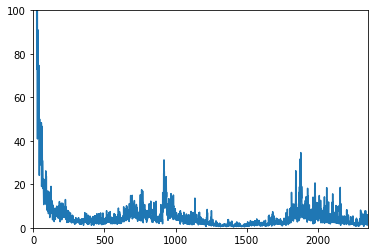

In [14]:
plt.plot(range(len(losses_list)), losses_list)
print(len(losses_list))
plt.xlim([0,2350])
plt.ylim([0,100])

In [15]:
model.to(device).eval()  
# eval mode (batchnorm uses moving mean/variance instead of mini-batch mean/variance)

# evaluation: MSE loss of center predictions
# evaluation: MSE loss of degree predictions
criterion = nn.MSELoss()


print(len(test_loader))
print(len(train_loader))
print(len(test_loader))
print(len(test_loader))

with torch.no_grad():
    total_err = 0
    n_total = 0
    for i_batch, (images, labels) in enumerate(test_loader):
    #for i_batch, (images, labels) in enumerate(train_loader):
        print('i_batch', i_batch)
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images).to(device)
        diff = outputs - labels
        diff = torch.sum(diff, 0) #column sum
        total_err += diff
        #loss = criterion(outputs, labels)
        #print(loss)
        #x, y, orient = outputs.squeeze() # remove extra dim, so not nested list of list
        #true_x, true_y, true_orient = labels.squeeze()
        #xy_err +=criterion( torch.Tensor([x,y]), torch.Tensor([true_x, true_y]))
        #orient_err += criterion(orient, true_orient)
        #print(n_total)
        #n_total += 1
        #_, predicted = torch.max(outputs.data, 1)
        #total += labels.size(0)
        #correct += (predicted == labels).sum().item()
print(n_total * batch_size)

10
47
10
10
i_batch 0
i_batch 1
i_batch 2
i_batch 3
i_batch 4
i_batch 5
i_batch 6
i_batch 7
i_batch 8
i_batch 9
0


300


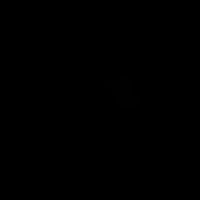

tensor([ 24.1714, -94.1190,  66.3231], device='cuda:0')
tensor([ 0.0806, -0.3137,  0.2211], device='cuda:0')

 ----------------------------
Across a total of 300 images, the average error was 0.08 and -0.31 pixels for x and y, and 12.67 degrees for orientation

 ----------------------------


In [16]:
n_total = len(test_loader.dataset)

print(n_total)
from IPython.display import display # to display images

import torchvision
img = torchvision.transforms.ToPILImage()(images[0].cpu())
display(img)

avg_err = total_err / n_total 
print(total_err)
print(avg_err)
xerr, yerr, orienterr = avg_err
print('\n ----------------------------')
print('Across a total of %d images, the average error was %0.2f and %0.2f pixels for x and y, \
and %0.2f degrees for orientation' % (n_total, xerr, yerr, math.degrees(orienterr)))
print('\n ----------------------------')

# diagnostics

In [17]:
from IPython.display import display # to display images
#font = ImageFont.truetype("Arial.ttf",14) # OSError: cannot open resource
font = ImageFont.truetype("/usr/share/fonts/dejavu/DejaVuSans.ttf",14)
def imshow_coord(img, a_label):
    img = torchvision.transforms.ToPILImage()(img)
    draw = ImageDraw.Draw(img)
    #draw.text((10, 25), '(' + np.array2string(np.around(a_label.numpy()), separator=', ') + ')')
    x,y,orient = a_label
    rect_vertices = makeRectangle(5, 15, orient, offset=(x,y))
    draw.polygon(rect_vertices, fill='red')
    draw = draw_crosspointer(a_label, draw, 'green', 'white', length=8)
    display(img)
    
def draw_crosspointer(xy, draw, fillcolor_X='green', fillcolor='white', length=2):
    a,b, orient = tuple(xy)
    draw.line((a-length, b+length, a+length, b-length), fill=fillcolor_X)
    draw.line((a-length, b-length, a+length, b+length), fill=fillcolor_X)
    draw.point((a,b))
    return draw

x,y truth tensor([179.0000,  80.0000,   1.0472])
x,y guess by net tensor([179.5202,  79.1828,   1.5876], device='cuda:0')
image size:  torch.Size([3, 200, 200])
tensor(0.1539, device='cuda:0')
net output: 


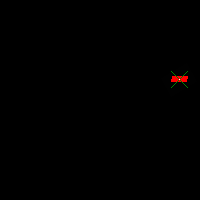

truth label: 


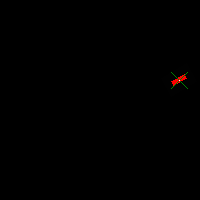

In [40]:
import torchvision 
import matplotlib.pyplot as plt
import copy
# get some random training images
with torch.no_grad():
    dataiter = iter(train_loader)
    images, labels = dataiter.next()
    outputs = model(images)
    
    # show images
    #imshow_coord(torchvision.utils.make_grid(images), (outputs))


    # print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                                  # for j in range(4)))
        
    loss = criterion(outputs.to(device), labels.to(device))
 
n =0 
#print(len(labels))
print('x,y truth', labels[n])
print('x,y guess by net', outputs[n])

images_copy = copy.deepcopy(images)
print('image size: ', images_copy[n].size())
print(loss)
print('net output: ')
imshow_coord(images_copy[n], outputs[n])
print('truth label: ')
imshow_coord(images_copy[n], labels[n])

#imagePIL = torchvision.transforms.ToPILImage()(images[n])
#print('PIL image size', imagePIL.size)
#imagePIL.save('test.png')
#display(imagePIL)

#display(Image.open('./data/rect'+str(n)+'.png'))

In [33]:
%matplotlib inline
#im = Image.open("Mew.jpg")
n = 12
n = np.random.rand()*len(images)
n = int(n)

image = io.imread('./data/rect'+str(n)+'.png')
image_tensor = torch.FloatTensor(image).permute(2, 0, 1) #PIL and torch expect difft orders
coords = torch.FloatTensor(true_coords[n])
with torch.no_grad():
    output = model(image_tensor)

print(true_coords[n])
print(output)
x,y,orient = output.cpu().numpy().flatten()
imshow_coord(image, (x,y, orient))
plt.imshow(image)

NameError: name 'true_coords' is not defined

In [ ]:
#img = Image.new('RGB', (300,400), 'gray')
import seaborn as sns
sns.set_style("ticks")
n = 0
#imshow_coord(images[n], outputs[n], labels[n])

print(images.size())
a = torchvision.utils.make_grid(images)
print(a.max(), a.min(), a.size())
#a = a / 2 + 0.5     # unnormalize

a = a.cpu().numpy()
a = np.transpose(a,(1,2,0))
print(a.shape)
print(a.ndim)

#ran = a.max() - a.min()
#a = (a/ran )

fig,ax = plt.subplots(1)
# Display the image
ax.imshow(a)
#x,y = labels[0].numpy()
#plt.scatter(x,y, color='g', marker='x', linewidth='1')
labels = labels.cpu()

plt.rcParams['figure.figsize'] = [30,5]
import matplotlib.patches as patches
for i in range(len(labels)):
    x,y, orient = labels[i].numpy()

# class matplotlib.patches.Rectangle(xy, width, height, angle=0.0, **kwargs)[source]

    rect = patches.Rectangle((x + i*IMG_X, y), 1,20,angle=orient, fill=True, color='orange')
    ax.add_patch(rect)
    ax.scatter(x + i*IMG_X, y, color='r', marker='x', linewidth='1')
#plt.imshow(np.transpose(a, (2,0,1)))

In [ ]:
import seaborn as sns
sns.set()
f = plt.subplot()
f.plot(range(len(losses_list)), losses_list)

plt.rcParams['figure.figsize'] = [30, 5]
xposition = np.array(range(num_epoch))  * (total_step)
#print(xposition)
for xc in xposition:
    #plt.axvline(x=xc, color='k', linestyle='--')
    pass
    


In [ ]:
g = plt.subplot()
trunc = 100
g.plot(range(trunc), losses_list[-trunc:])

plt.show()

# Don't run the following cell (takes long time)

In [ ]:
num_epochs = [10,20,50,70,100,150] 
num_classes = 3 # predicting x,y,orientation
batch_size = 5 
learning_rates = [0.001, 0.005, 0.01, 0.1]

meta_losses_list = []
for i in range(len(num_epochs)):
    num_epoch = num_epochs[i]
    learning_rate = learning_rates[0]
    losses_list = []
    print('Training model now... with: %d num_epoch and %d learning rate' % (num_epoch, learning_rate))
    
    total_step = len(train_loader)
    for epoch in range(num_epoch):
        for i_batch, (images, labels) in enumerate(train_loader):

            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()

            # Forward pass
            outputs = model(images)
            # magnify orientation loss
            outputs[2] *= 10
            labels[2] *= 10
            loss = criterion(outputs, labels)

            # Backward and optimize
            loss.backward()
            optimizer.step()

            if (i_batch+1) % 1 == 0:
                print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(epoch+1,
                                                                          num_epochs,
                                                                          i_batch+1,
                                                                          total_step,
                                                                          loss.item()))
                losses_list.append(loss.item())
    meta_losses_list.append(losses_list)

In [ ]:
fig = plt.subplots()
trunc = 100
for l in meta_losses_list:
    plt.plot(range(len(l[-trunc:])), l[-trunc:])
plt.legend()
plt.show()